In [7]:
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
from torchmetrics.functional.text.rouge import rouge_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import subprocess
import tempfile
import os

In [2]:
split = pd.read_csv("split_0.csv", sep=",")
id_map = pd.read_csv('id_maps.tsv', sep="\t", header=None)
with open("uniref50_gpt_data.pkl", "rb") as f:
    pika = pickle.load(f)

seqs = {k: v["sequence"] for k, v in pika.items()}
next(iter(seqs.items()))

('A0A009IHW8',
 'MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENARIQSKLSDLQKKKIDIDNKLLKEKQNLIKEEILERKKLEVLTKKQQKDEIEHQKKLKREIDAIKASTQYITDVSISSYNNTIPETEPEYDLFISHASEDKEDFVRPLAETLQQLGVNVWYDEFTLKVGDSLRQKIDSGLRNSKYGTVVLSTDFIKKDWTNYELDGLVAREMNGHKMILPIWHKITKNDVLDYSPNLADKVALNTSVNSIEEIAHQLADVILNR')

In [3]:
split["sequence"] = split.uniprot_id.map(seqs)
split

,uniprot_id,protein_length,uniref_id,split,sequence
0,A2YUL5,389,UniRef50_Q6Z256,train,MDSGNVVVCDNGTGYVKCGFAGENFPTSVFPCVVGRPLLRYEESLQ...
1,Q07646,335,UniRef50_Q07646,test,MVRRDRLRRMREWWVQVGLLAVPLLAAYLHIPPPQLSPALHSWKTS...
2,A4WMD4,264,UniRef50_A4WMD4,train,MPDKKRRVTDFVKGGGPYVWVTAYDYPTAKLVDEAGVDGILVGDSL...
3,O07165,170,UniRef50_O07165,train,MRVEGQLGDEVVTIKATSIARRLHGKSHYGKMYEDRLQLSLIEAAY...
4,Q3UV31,285,UniRef50_Q3UV31,train,MVHKKRGGVTSWLFRKSPVHNVLPLLHSWESCHQATGCGVQLCHPT...
...,...,...,...,...,...
252598,Q9NS28,235,UniRef50_Q9NS28,train,METTLLFFSQINMCESKEKTFFKLIHGSGKEETSKEAKIRAKEKRN...
252599,Q9TTU2,172,UniRef50_Q8VCP8,train,MRLPNILLTGTPGVGKTTLGKELASRSGLKYVNVGDLAREGELYDG...
252600,Q7TTW6,268,UniRef50_Q7V8W2,train,MAERTLVGLALKVGPLGEHDRLLSLLSDAEGVTRLAVPGARRPKSS...
252601,O00399,190,UniRef50_O00399,train,MAEKTQKSVKIAPGAVVCVESEIRGDVTIGPRTVIHPKARIIAEAG...


In [4]:
def write_fasta(data, file):
    for idx, row in data.iterrows():
        file.write(f">{row['uniprot_id']}\n{row['sequence']}\n")
    file.flush() 

In [20]:
cmd = ["jackhmmer", "-N", "5", "-E", "1", "--tblout", "hmmer/jack_out2.txt"]

# match_dict = {}
df = split.copy()
seed = 1
np.random.seed(seed)
tt = len(df)
progress = tqdm(total=tt)
df = df[~df.uniprot_id.isin(al_done)]
while len(df) > 0:
    if len(df) > 1:
        g = np.random.choice(df["uniprot_id"], 1)[0]
        query_path = tempfile.NamedTemporaryFile(mode='w+', delete=False)
        ref_path = tempfile.NamedTemporaryFile(mode='w+', delete=False)
        write_fasta(df[df.uniprot_id == g], query_path)
        write_fasta(df[df.uniprot_id != g], ref_path)

        subprocess.run(cmd + [query_path.name, ref_path.name], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        try:
            res = pd.read_csv("hmmer/jack_out2.txt", delim_whitespace=True, comment='#', header=None)
            matches = [g] + res[0].to_list()
        except pd.errors.EmptyDataError:
            res = pd.DataFrame()
            matches = [g]
        query_path.close()
        ref_path.close()
        os.unlink(query_path.name)
        os.unlink(ref_path.name)
    else:
        matches = [df.uniprot_id.item()]
    match_dict[len(match_dict) + 1] = matches
    df = df[~df.uniprot_id.isin(matches)]
    progress.n = tt - len(df)
    progress.refresh()

with open(f"hmmer/evo_groups_seed_{seed}.pkl", "wb") as f:
    pickle.dump(match_dict, f)
progress.close()

  0%|          | 0/252603 [00:00<?, ?it/s]

100%|██████████| 252603/252603 [2:53:31<00:00, 24.26it/s] 


In [32]:
evo_groups = sorted(match_dict.values(), key=len, reverse=True)
evo_map = {v: str(i) for i, ids in enumerate(evo_groups[50:100]) for v in ids}
len(evo_groups[0]), len(match_dict)


(4250, 13767)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = plt.cm.get_cmap('Set2')
colors = cmap.colors

colors_with_alpha = [(r, g, b, 0.5) for r, g, b in colors]

In [33]:
with open("prt_pca_umap.pkl", "rb") as f:
    ump = pickle.load(f)
top100_df = id_map[id_map[2].isin(id_map[2].value_counts().iloc[:100].index.to_list())]
top100_map = {key: value for key, value in zip(top100_df[0], top100_df[2])}
ump.obs["clusters"] = ump.obs[0].map(top100_map)
ump = ump[ump.obs[0].isin(pika)].copy()
ump.obs["evo"] = ump.obs[0].map(evo_map)
ump

AnnData object with n_obs × n_vars = 257154 × 1024
    obs: 0, 'clusters', 'evo'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


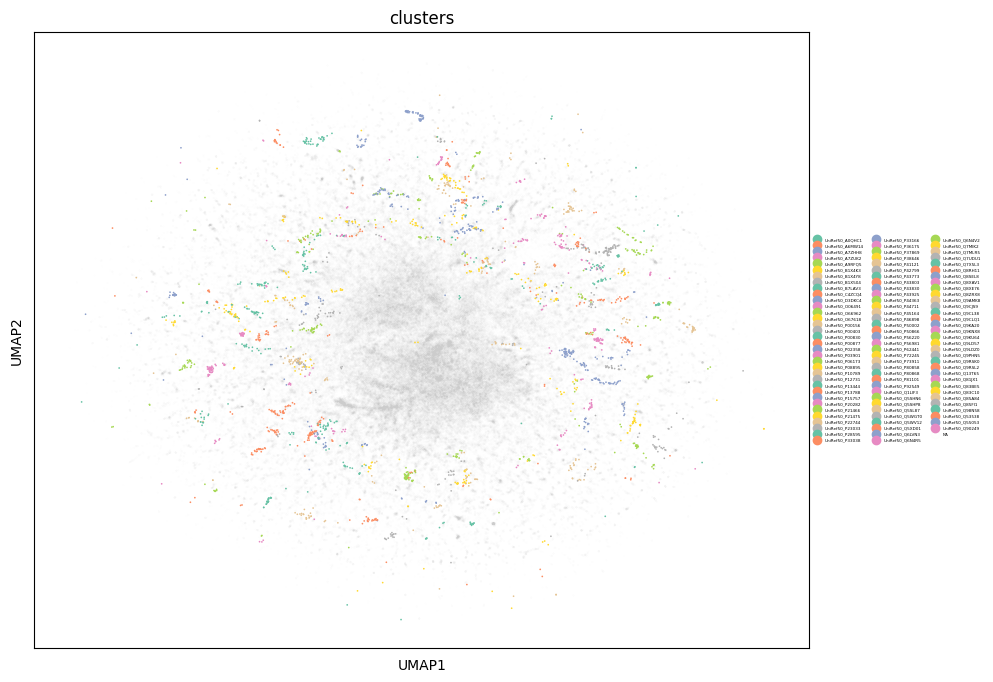

/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


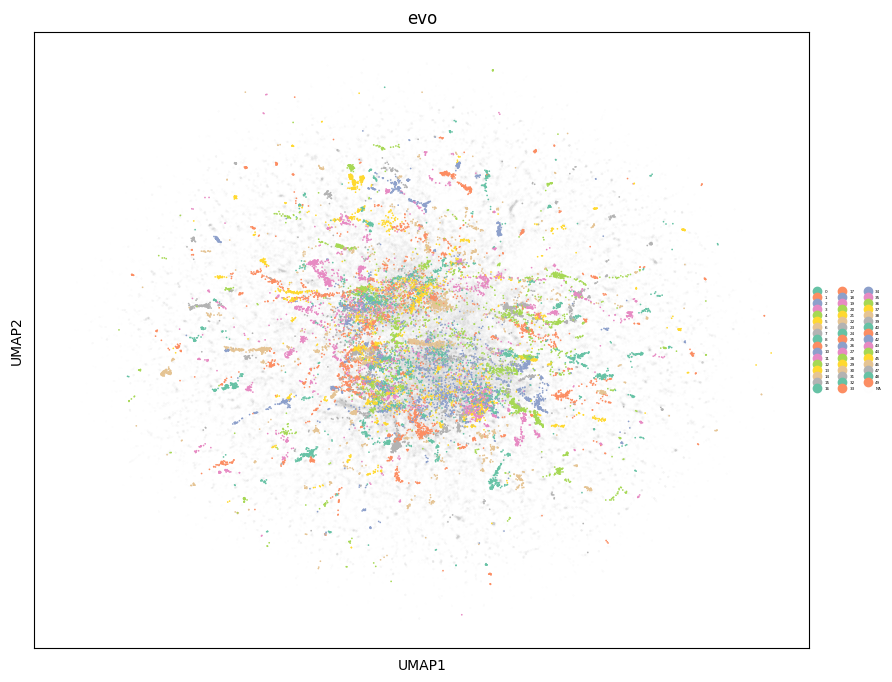

In [34]:
with plt.rc_context({'figure.figsize':(10, 8)}):
    sc.pl.umap(ump, color="clusters", size=6, palette=colors_with_alpha, legend_fontsize=3, edges=False, na_color = (0.8, 0.8, 0.8, 0.02))
    sc.pl.umap(ump, color="evo", size=6, palette=colors_with_alpha, legend_fontsize=3, edges=False, na_color = (0.8, 0.8, 0.8, 0.02))

In [38]:
s0 = pd.read_csv("/data/buckets/rrx-ada-dev/PertPrompt/data/s1.csv")
sum([1 if i in pika else 0 for i in s0.uniprot_id]), s0.split.value_counts()

(257167,
 split
 train    237740
 test      18134
 val        1293
 Name: count, dtype: int64)

In [57]:
seed = 0
np.random.seed(seed)
test_val = np.random.choice(range(len(evo_groups)), int(len(evo_groups) * 0.075) + 1, replace=False)
tests = np.random.choice(test_val, int(len(test_val) * 0.9), replace=False)
vals = [i for i in test_val if i not in tests]

test_set = [i for j, ids in enumerate(evo_groups) for i in ids if j in tests]
val_set = [i for j, ids in enumerate(evo_groups) for i in ids if j in vals]
len(test_set), len(val_set)

(14166, 1612)

In [58]:
s0["split"] = "train"
s0.loc[s0.uniprot_id.isin(test_set), "split"] = "test"
s0.loc[s0.uniprot_id.isin(val_set), "split"] = "val"
s0.split.value_counts()

split
train    241389
test      14166
val        1612
Name: count, dtype: int64

In [63]:
s0 = s0.drop("Unnamed: 0", axis=1)
s0

,uniprot_id,protein_length,uniref_id,split
0,A0A009IHW8,269,UniRef50_A0A009IHW8,train
1,A0A067XGX8,512,UniRef50_A0A067XH53,train
2,A0A067XH53,533,UniRef50_A0A067XH53,train
3,A0A068BGA5,456,UniRef50_A0A068BGA5,test
4,A0A072VHJ1,481,UniRef50_A0A072VHJ1,train
...,...,...,...,...
257162,Q9ZWB3,471,UniRef50_Q9ZWB3,train
257163,S3DQP8,358,UniRef50_S3DQP8,train
257164,V6F510,297,UniRef50_V6F510,test
257165,W6KHH6,293,UniRef50_W6KHH6,test


In [65]:
s0.split.value_counts()
# s0.to_csv("seed_1.csv")

split
train    241389
test      14166
val        1612
Name: count, dtype: int64